<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./316_fire_california_2020_Sentinel-3_SLSTR_NRT_AOD_L2.ipynb"><< 316 Californian Fires 2020 - Sentinel-3 SLSTR NRT AOD</a><span style="float:right;"><a href="./318_fire_indonesia_2020.ipynb">318 Indonesian Fires 2020 - Multi-data >></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES - FIRE</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** module is a prerequisite:   
- [214 - Metop-A/B/C GOME-2 - Absorbing Aerosol Index - Level 3](../20_data_discovery/214_Metop-ABC_GOME-2_AAI_L3_load_browse.ipynb)
- [215 - Metop-B GOME-2 - Absorbing Aerosol Height - Level 2](../20_data_discovery/215_Metop-B_GOME-2_AAH_L2_load_browse.ipynb)
- [232 - Metop-A/B IASI - Carbon Monoxide - Level 2](../20_data_discovery/232_Metop-AB_IASI_CO_L2_load_browse.ipynb)


It is recommended to go through the module before you start with this module.
</div>

<hr>

# 3.1.7 Discover Indonesian Fires 2015

In 2015, devastating wildfires broke out in Indonesia. According to [Reuters](https://www.reuters.com/article/us-indonesia-politics-haze-analysis-idUSKCN1UV0ZJ), "Between June and October that year, about 2.6 million hectares (6.4 million acres) of land burned in Indonesia, mainly on Sumatra and Borneo islands, said a 2016 World Bank report. A Harvard University study linked the 2015 haze to more than 100,000 premature deaths in Indonesia, Malaysia and Singapore."

The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the fires during 8-9 September 2015 with the following data products:
<a id="top"></a>
- [Metop-A/B IASI - Total Column Carbon Monoxide (CO) - Level 2](#iasi_co)
- [AC-SAF - Metop-B GOME-2 - Formaldehyde (HCHO)](#gome2_hcho)
- [AC-SAF - Metop-A/B GOME-2 - Absorbing Aerosol Index (AAI)](#gome2_aai)
- [AC-SAF - Metop-B GOME-2 - Absorbing Aerosol Height (AAH)](#gome2_aah)

<br>

<img src='../img/indonesia_fires_2015_1.jpg' alt='Indonesia Fires, source: https://www.theguardian.com/sustainable-business/2015/nov/11/indonesia-forest-fires-explained-haze-palm-oil-timber-burning' align='centre' width='60%'></img>

<i>Caption: A villager tries to extinguish a peatland fire on the outskirts of Palangkaraya city, Central Kalimantan. </i><br> Photograph: Bay Ismoyo/AFP/Getty, Images as featured in [The Guardian](https://www.theguardian.com/sustainable-business/2015/nov/11/indonesia-forest-fires-explained-haze-palm-oil-timber-burning).

<hr>

#### Load required libraries

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from skimage import exposure

from netCDF4 import Dataset
import pandas as pd

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [4]:
%run ../functions.ipynb

<hr>

## <a id="iasi_co"></a>Metop-A/B IASI Level 2 Carbon monoxide (CO)

IASI Level 2 CO data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `txt` format in 2015. You can use the Python library [pandas](https://pandas.pydata.org) to access and manipulate datasets in `txt` format. 

### <a id='step1'></a>Load the Metop-A IASI Level 2 data with `pandas`

IASI Total Column Carbon Monoxide data are disseminated in `.txt` format. You can easily load the .txt file with the pandas function `pd.read_csv()`, using an empty string as seperator.

In [5]:
iasi_file = '../eodata/iasi/txt/co/2a/2015/09/09/iasi_CO_LATMOS_ULB_20150909_v20140922.txt'


In [6]:
iasi_co = pd.read_csv(iasi_file, sep=" ", header = None)
iasi_co.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,56.66836,-69.74904,20150909,259,96.95,1,0,0,0,0,...,2.365902,2.251876,2.008893,1.770233,1.599311,1.454534,1.330921,1.202729,1.080917,-0.330595
1,56.40126,-70.50591,20150909,259,96.66,2,0,0,0,0,...,2.374669,2.320618,2.088976,1.803872,1.609957,1.452753,1.323877,1.195579,1.081573,-0.339866
2,56.17440,-70.23203,20150909,259,96.88,3,0,0,0,0,...,2.360759,2.327788,2.126293,1.846213,1.642612,1.472643,1.335170,1.195982,1.065666,-0.340553
3,57.08389,-67.72364,20150909,259,97.82,0,0,0,0,0,...,2.274544,2.147204,1.867447,1.584539,1.403302,1.252968,1.125439,1.011367,0.918079,-0.237075
4,57.28990,-67.95295,20150909,259,97.63,1,0,0,0,0,...,2.352564,2.218646,1.932256,1.626201,1.451941,1.326538,1.213669,1.082594,0.969588,-0.247227


#### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) to load the `Total Column Carbon Monoxide` information into a `xarray.DataArray`.

The data holds a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information into a `xarray.DataArray` as well.

In [7]:
iasi_co_da = generate_xr_from_1D_vec(file=iasi_co,
                                     lat_path=0, 
                                     lon_path=1, 
                                     variable=iasi_co[20], 
                                     parameter_name='co', 
                                     longname='IASI Carbon Monoxide Total Column', 
                                     no_of_dims=1, 
                                     unit='molec./cm-2')

iasi_co_da

<xarray.DataArray 'co' (ground_pixel: 468375)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 1.720793e+18,
       2.011679e+18, 1.710957e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 44.62 40.76 43.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 151.8 161.2 151.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

In [8]:
iasi_co_qf_da = generate_xr_from_1D_vec(file=iasi_co,
                                        lat_path=0, 
                                        lon_path=1,
                                        variable=iasi_co[15], 
                                        parameter_name='qf', 
                                        longname='Super Quality Flag', 
                                        no_of_dims=1, 
                                        unit='-')

iasi_co_qf_da

<xarray.DataArray 'qf' (ground_pixel: 468375)>
array([0, 0, 0, ..., 1, 1, 1])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 44.62 40.76 43.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 151.8 161.2 151.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Super Quality Flag
    units:      -

### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function [generate_masked_array](../functions.ipynb#generate_masked_array) allows you to flag out the quality flags. You want to flag all pixels with a quality flag equals 0.

In [9]:
iasi_co_masked = generate_masked_array(xarray=iasi_co_da,
                                       mask=iasi_co_qf_da,
                                       threshold=0,
                                       operator='=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 363488)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 2.566273e+18,
       1.775954e+18, 2.427362e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 45.43 46.77 44.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 158.2 151.8 160.0
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

### Load the Metop-B IASI Level 2 data with `pandas`

Let us now use `pandas` to load the data from Metop-B. We will repeat the same steps as we did for Metop-A.

In [10]:
iasi_file_b = '../eodata/iasi/txt/co/2b/2015/09/09/iasi_CO_LATMOS_ULB_metopb_20150909_v20140922.txt'


In [11]:
iasi_co_b = pd.read_csv(iasi_file_b, sep=" ", header = None)
iasi_co_b.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-45.95519,143.20297,20150909,253,60.37,1,1,0,0,0,...,1.679389,1.540492,1.349874,1.148153,0.968703,0.823212,0.699236,0.593768,0.498157,0.006721
1,-45.64839,140.32381,20150909,254,61.52,2,1,0,0,1,...,2.013606,1.871402,1.652351,1.406361,1.189546,1.016303,0.867966,0.741711,0.622416,-0.041041
2,-45.09610,136.20546,20150909,255,63.24,1,0,0,0,0,...,1.787922,1.686547,1.515197,1.303339,1.102482,0.934500,0.792027,0.669474,0.561571,-0.011777
3,-45.13663,136.44952,20150909,255,63.14,2,1,0,0,0,...,2.030403,1.924646,1.730961,1.488511,1.263497,1.075897,0.914956,0.775222,0.646970,-0.034783
4,-44.83897,135.61980,20150909,255,63.39,0,1,0,0,0,...,1.921038,1.827848,1.649180,1.417723,1.196915,1.012524,0.856973,0.723208,0.603006,-0.033066


### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) to load the `Total Column Carbon Monoxide` information into a `xarray.DataArray`.

The data holds a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information into a `xarray.DataArray` as well.

In [12]:
iasi_co_b_da = generate_xr_from_1D_vec(file=iasi_co_b,
                                     lat_path=0, 
                                     lon_path=1, 
                                     variable=iasi_co_b[20], 
                                     parameter_name='co', 
                                     longname='IASI Carbon Monoxide Total Column', 
                                     no_of_dims=1, 
                                     unit='molec./cm-2')

iasi_co_b_da

<xarray.DataArray 'co' (ground_pixel: 483390)>
array([1.281433e+18, 1.314173e+18, 1.308412e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.65 -45.1 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 140.3 136.2 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

In [13]:
iasi_co_b_qf_da = generate_xr_from_1D_vec(file=iasi_co_b,
                                        lat_path=0, 
                                        lon_path=1,
                                        variable=iasi_co_b[15], 
                                        parameter_name='qf', 
                                        longname='Super Quality Flag', 
                                        no_of_dims=1, 
                                        unit='-')

iasi_co_b_qf_da

<xarray.DataArray 'qf' (ground_pixel: 483390)>
array([0, 1, 0, ..., 0, 0, 0])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.65 -45.1 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 140.3 136.2 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Super Quality Flag
    units:      -

### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function [generate_masked_array](../functions.ipynb#generate_masked_array) allows you to flag out the quality flags. You want to flag all pixels with a quality flag equals 0.

In [14]:
iasi_co_b_masked = generate_masked_array(xarray=iasi_co_b_da,
                                       mask=iasi_co_b_qf_da,
                                       threshold=0,
                                       operator='=')
iasi_co_b_masked

<xarray.DataArray (ground_pixel: 378069)>
array([1.281433e+18, 1.308412e+18, 1.386403e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.1 -45.14 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 136.2 136.4 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

### Combine the two Carbon monoxide data arrays from Metop-A and Metop-B `xarray.concat`

Now, you concatenate the `xarray.DataArrays` from Metop-A and Metop-B into one single `DataArray`. You can use the function `xarray.concat` for it and use the dimension `ground_pixel` as concatenation dimension.

In [15]:
co_2ab_da = xr.concat([iasi_co_masked,iasi_co_b_masked],dim='ground_pixel')
co_2ab_da

<xarray.DataArray (ground_pixel: 741557)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... -60.02 -60.07 -60.22
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

### Bin the Metop-A/B IASI Level-2 data onto a regular two-dimensional grid

The next step is to bring the ground pixel information of the `co_2ab_da` array onto a regular two-dimensional grid. This process is called *binning*. In preparation, you store the data values of `latitude`, `longitude` and `CO_total_column` as variables x, y, z.

In [16]:
y = co_2ab_da.latitude.data
x = co_2ab_da.longitude.data
z = co_2ab_da.data

<br>

### Bin the data onto a 2D-grid with `np.histogram2d`

With `np.histogram2d`, you can bin the data onto a pre-defined two-dimensional grid (called bins). By assigning the data value object `z` to the keyword argument `weights`, the bin gets assigned the data value of the point that falls into the cell.

Since there will be more data points assigned to one cell (bin), you also have to create a `counts` array, which sums up the number of data points fallen into a bin. With this `counts` array, you can build the arithmetic mean of all the data points fallen into a bin.

The example below builds a regular grid of 1 deg x 1 deg.

In [17]:
zi, yi, xi = np.histogram2d(y, x, bins=(180,360), weights=z, normed=False)
counts, _, _ = np.histogram2d(y, x, bins=(180,360))
    
zi = zi / counts
zi

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan, 9.16743000e+17, 9.12972525e+17, ...,
                   nan,            nan,            nan],
       ...,
       [1.97650900e+18, 2.13348800e+18,            nan, ...,
        2.03848750e+18,            nan, 2.29839800e+18],
       [1.94472700e+18,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

You can create a `xarray.DataArray` from the binned information, which gives you flexibility in further handling the regularly gridded ozone values.

<br>

### Create a `xarray.DataArray` of the regular gridded Carbon monoxide information

You can create a `xarray.DataArray` with the constructor `DataArray()`. Define the array with two dimensions, `latitude` and `longitude`, but add `time` as an additional coordinate information.

In [18]:
xarray_ab = xr.DataArray(
                zi,
                dims=['latitude','longitude'],
                coords={
                    'time': pd.to_datetime('2015-09-09'),
                    'latitude':(['latitude'], yi[:-1]),
                    'longitude':(['longitude'],xi[:-1])
                },
                attrs={'long_name': co_2ab_da.long_name, 'units': co_2ab_da.units},
                name='CO'
            )

xarray_ab

<xarray.DataArray 'CO' (latitude: 180, longitude: 360)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan, 9.16743000e+17, 9.12972525e+17, ...,
                   nan,            nan,            nan],
       ...,
       [1.97650900e+18, 2.13348800e+18,            nan, ...,
        2.03848750e+18,            nan, 2.29839800e+18],
       [1.94472700e+18,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
    time       datetime64[ns] 2015-09-09
  * latitude   (latitude) float64 -87.88 -86.9 -85.91 ... 86.27 87.26 88.24
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

###  <a id="visualize"></a>Visualize the Metop-A/B IASI data

#### Visualize the data array with the function `visualize_pcolormesh`

The final step is to visualize the gridded data with the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'IASI L2 METOP-A/B IASI Carbon Monoxide Total Column from 2015-09-09'}>)

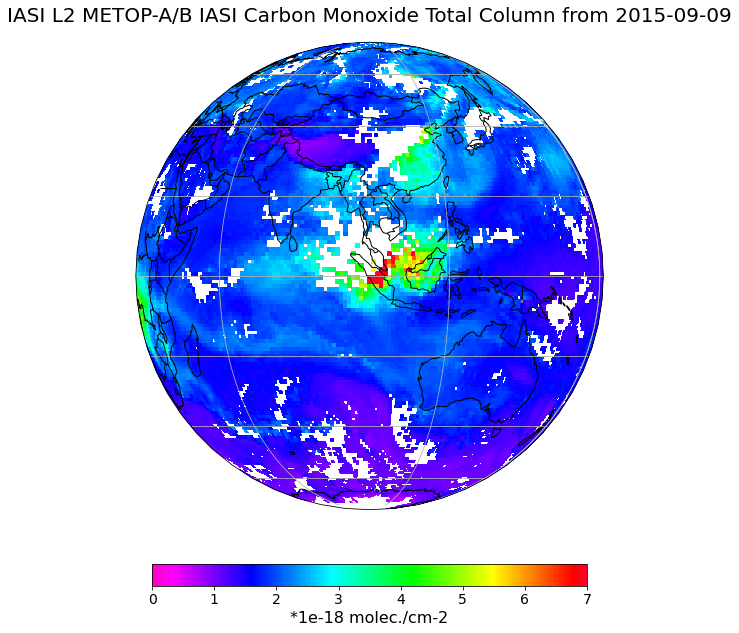

In [19]:
visualize_pcolormesh(data_array=xarray_ab*1e-18, 
                     longitude=xarray_ab.longitude, 
                     latitude=xarray_ab.latitude, 
                     projection=ccrs.Orthographic(100,0), 
                     color_scale='gist_rainbow_r', 
                     unit='*1e-18 ' + xarray_ab.units, 
                     long_name="IASI L2 METOP-A/B " + xarray_ab.long_name + " from " + str(xarray_ab.time.data)[0:10],
                     vmin=0, 
                     vmax=7)

^ [Return to the top](#top)

## <a id='gome2_hcho'></a>AC-SAF Metop-B GOME-2 Level 2 HCHO data

Formaldehyde (HCHO) indicates the presence of elevated absorbing aerosols in the Earth's atmosphere. The aerosol types that are mostly seen in the HCHO are desert dust and biomass burning aerosols. 

The AC-SAF Metop-B GOME-2 Level 2 Formaldehyde data is disseminated in the `HDF5` and `BUFR` format. [xarray](http://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) are two Python libraries you can use to access and manipulate datasets in `HDF5` format.

### <a id='disover_aah'></a>Discover the structure of AC-SAF Metop-B GOME-2 Level 2 product data files

The data in a HDF5 file is organized in groups. Metop-B GOME-2 Level 2 data contain five groups:

* `CLOUD_PROPERTIES`
 * Retrieve cloud properties
* `DETAILED_RESULTS`
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* `GEOLOCATION`
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* `META_DATA`
 * Product Metadata
* `TOTAL_COLUMNS`
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors

You can load a `HDF5` file with the `Dataset` constructor of the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library. Load the file in `diskless non-persistent` mode by setting the `diskless` argument to `True` and the `persist` argument to `False`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

In [20]:
file_name = '../eodata/gome2/hcho/2015/09/09/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO-OClO_L2_20150909010045_054_METOPB_15434_DLR_04.HDF5'
file = Dataset(file_name, diskless=True, persist=False)

groups = file.groups.keys()
groups

dict_keys(['CLOUD_PROPERTIES', 'DETAILED_RESULTS', 'GEOLOCATION', 'META_DATA', 'TOTAL_COLUMNS'])

### <a id='open_hcho'></a>Open a `HDF5` group content as `xarray.Dataset` object

In a next step, you can make use of the `xarray.backends.NetCDF4DataStore` feature of the [xarray](http://xarray.pydata.org/en/stable/index.html) library to open the `HDF5` group you are interested in as a xarray `Dataset` object. It is important to know that you can only get hold of one `HDF5` group item at the time.

As an example, you can load the `TOTAL_COLUMNS` group and open it as xarray `Dataset`. You see that the data has one dimension: `phony_dim_20`.

In [21]:
data = file['TOTAL_COLUMNS']
xr_data = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
xr_data

<xarray.Dataset>
Dimensions:         (phony_dim_20: 15264)
Dimensions without coordinates: phony_dim_20
Data variables:
    BrO             (phony_dim_20) float32 ...
    BrO_Error       (phony_dim_20) float32 ...
    H2O             (phony_dim_20) float32 ...
    H2O_Error       (phony_dim_20) float32 ...
    HCHO            (phony_dim_20) float32 ...
    HCHO_Error      (phony_dim_20) float32 ...
    NO2             (phony_dim_20) float32 ...
    NO2Tropo        (phony_dim_20) float32 ...
    NO2Tropo_Error  (phony_dim_20) float32 ...
    NO2_Error       (phony_dim_20) float32 ...
    O3              (phony_dim_20) float32 ...
    O3_Error        (phony_dim_20) float32 ...
    OClO            (phony_dim_20) float32 ...
    OClO_Error      (phony_dim_20) float32 ...
    SO2             (phony_dim_20) float32 ...
    SO2_Error       (phony_dim_20) float32 ...

### <a id='select_hcho'></a>Select and retrieve one specific parameter from a `xarray.Dataset` object

We are interested in the `HCHO` parameter, which contains information on the vertical column density of HCHO (cloud screened). With `xarray`, you can retrieve the parameter using square brackets `[]` and the name of the parameter of interest. 

In [22]:
hcho = xr_data['HCHO']
hcho

<xarray.DataArray 'HCHO' (phony_dim_20: 15264)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Dimensions without coordinates: phony_dim_20
Attributes:
    Title:          Vertical column density of HCHO
    Unit:           mol/cm2
    CheckSum:       1585008046
    FillValue:      -1.0
    ValueRangeMin:  -3.609892e+16
    ValueRangeMax:  5.0599353e+16

### <a id='build_xr_hcho'></a>Build a `xarray.DataArray` object for a Metop-B GOME-2 Level 2 parameter

For easier handling and plotting of the parameters, you can combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

You can make use of the function `generate_xr_from_1D_vec` which takes the following kwargs:
* `file` - the data file you want to load the data information from
* `lat_path` - internal paths to the latitude information of the HDF5 file
* `lon_path` - internal paths to the longitude information of the HDF5 file
* `variable` - xarray.DataArray with the variable information
* `parameter_name` - Name of the variable
* `longname` - Long name information of the variable
* `no_of_dims` - Number of dimensions of the data file
* `unit` - unit of the variable

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` object with latitude and longitude information and the HCHO values as data values. The `DataArray` object contains 15238 ground pixels.

In [23]:
hcho_xr = generate_xr_from_1D_vec(file = file, 
                                 lat_path = 'GEOLOCATION/LatitudeCentre', 
                                 lon_path = 'GEOLOCATION/LongitudeCentre', 
                                 variable = hcho, 
                                 parameter_name = hcho.name, 
                                 longname = hcho.Title,
                                 no_of_dims = 1, 
                                 unit = hcho.Unit)

hcho_xr

<xarray.DataArray 'HCHO' (ground_pixel: 15264)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.68 65.97 66.25 ... -82.5 -82.82 -83.14
    longitude  (ground_pixel) float32 272.2 271.7 271.1 ... 92.69 91.59 90.43
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

### <a id='combine_hcho'></a>Combine multiple HDF5 files in a `xarray.DataArray` object

AC-SAF Metop-B GOME-2 Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, you can apply the function `load_l2_data_xr`, which loads multiple `HDF5` files and returns a `xarray.DataArray` object with all ground pixels of all files. The function makes internally use of the function `generate_xr_from_1D_vec`.

Let us load all the AC-SAF Metop-B GOME-2 Level 2 data files for 9 September 2015. 

In [24]:
directory='../eodata/gome2/hcho/2015/09/09'
hcho_da_mf = load_l2_data_xr(directory= directory,
                           internal_filepath='TOTAL_COLUMNS',
                           parameter='HCHO',
                           lat_path='GEOLOCATION/LatitudeCentre',
                           lon_path='GEOLOCATION/LongitudeCentre',
                           no_of_dims=1,
                           paramname=hcho.name,
                           unit=hcho.Unit,
                           longname=hcho.Title)

hcho_da_mf

<xarray.DataArray 'HCHO' (ground_pixel: 213285)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 65.91 66.2 66.48 ... -82.55 -82.88 -83.19
    longitude  (ground_pixel) float32 221.1 220.6 220.0 ... 16.48 15.41 14.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

##  <a id="visualize"></a>Visualize the Metop-B GOME-2 Level 2 HCHO data

If you visualize the data array containing ground pixel information from multiple files, you see that for one day, almost all part on Earth are covered by Metop-B GOME-2. You can use the function `visualize_scatter` to visualize the data as a scatter plot. 

Let us visualize the data using the `Orthographic` projection. Take note of the elevated values over the island of Borneo.

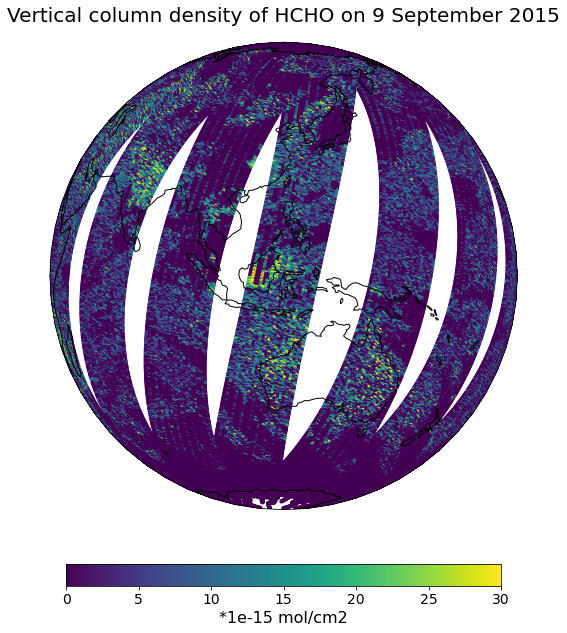

In [25]:
visualize_scatter(xr_dataarray=hcho_da_mf, 
             conversion_factor=1e-15,
             projection=ccrs.Orthographic(120), 
             vmin=0, 
             vmax=30, 
             point_size=10, 
             color_scale='viridis', 
             unit='*1e-15 ' + hcho_da_mf.units, 
             title=hcho_da_mf.long_name + " on 9 September 2015"
                 )

^ [Return to the top](#top)

## <a id='gome2_aai'></a>GOME-2 Level 3 AAI data

The GOME-3 Level 3 AAI data files can be downloaded from the TEMIS website in `NetCDF` data format. TEMIS offers the data of all three satellites Metop-A, -B and -C, which, combined, provide daily measurements for the entire globe. For our case study, we will use data from Metop-A and -B, as data from Metop-C was not available in 2015. The daily gridded data is available for each satellite.

### Load and inspect the structure of a single gridded data file from Metop-A

The data is in the folder `/eodata/gome2/aai/`. Since the data is distributed in the `NetCDF` format, you can use the xarray function `open_dataset()` to load one single file to better understand the data structure.

In [26]:
file = '../eodata/gome2/aai/2a/2015/09/09/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20150909-fv1.8.nc'
aai_gome2a = xr.open_dataset(file)
aai_gome2a

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 09-09-2015
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.8
    cdm_data_type:              Grid
    date_created:               20200909T070802Z
    source:                     GOME-2A AAI version 1.35
    platform:                   METOP-A
    sensor:                     GOME-2
    history:                    2020-09-09 07:08:02 - Product generated using...
    tracking_id:                610f87b0-6ac8-11e6-bdf4-0800200c9a66
    keywords:                   satellite, atmosphere, aerosols, absorbing ae...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    naming_authority:           knmi.nl
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    creator_name:               Royal Netherlands Meteorological Institute (K...
    creator_url:                http://www.knmi.nl
    creator_email:              tilstra@knmi.nl
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lat_resolution:  1.0
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the variable's `DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [27]:
aai_a = aai_gome2a['absorbing_aerosol_index']
aai_a


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

Let's repeat the above steps for the AAI data from Metop-B.

In [28]:
file = '../eodata/gome2/aai/2b/2015/09/09/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20150909-fv1.8.nc'
aai_gome2b = xr.open_dataset(file)
aai_gome2b

<xarray.Dataset>
Dimensions:                  (latitude: 180, longitude: 360)
Coordinates:
  * longitude                (longitude) float32 -179.5 -178.5 ... 178.5 179.5
  * latitude                 (latitude) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    absorbing_aerosol_index  (latitude, longitude) float32 ...
    number_of_observations   (latitude, longitude) int16 ...
    solar_zenith_angle       (latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 09-09-2015
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    product_version:            1.8
    cdm_data_type:              Grid
    date_created:               20200909T195339Z
    source:                     GOME-2B AAI version 1.35
    platform:                   METOP-B
    sensor:                     GOME-2
    history:                    2020-09-09 19:53:39 - Product generated using...
    tracking_id:                610f87b0-6ac8-11e6-bdf4-0800200c9a66
    keywords:                   satellite, atmosphere, aerosols, absorbing ae...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    naming_authority:           knmi.nl
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    creator_name:               Royal Netherlands Meteorological Institute (K...
    creator_url:                http://www.knmi.nl
    creator_email:              tilstra@knmi.nl
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lat_resolution:  1.0
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

In [29]:
aai_b = aai_gome2b['absorbing_aerosol_index']
aai_b


<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

### <a id='concat'></a>Concatenate the data from the two satellites Metop-A and -B

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A and -B and we call the dimension `satellite`. You can use the `concat()` function from the xarray library.

In [30]:
aai_concat = xr.concat([aai_a,aai_b], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 2, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

### <a id='combine'></a>Combine AAI data from the two satellites Metop-A and -B onto one single grid

Since the final aim is to combine the data from the two satellites Metop-A and -B onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reduced function `mean` to the `aai_concat` Data Array. The dimension (`dim`) to be reduced shall be the `satellite` dimension.

This function builds the average of all data points within a grid cell. The resulting `DataArray` has two dimensions `latitude` and `longitude`.

In [31]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (latitude: 180, longitude: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

### <a id='visualize'></a>Visualize AAI data with data from the two satellites Metop-A and -B combined on one single grid

Let's first define a bounding box for south-east Asia, with: `[-20, 15, 90, 140]`.

In [32]:
latmin = -20
latmax = 15.
lonmin = 90.
lonmax = 140.

The final step is to visualize the Absorbing Aerosol Index data. You can use the function `visualize_pcolormesh` for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by using `str(aai_gome2a.description.split()[4])`, you can add the valid time step extracted from the file name of `aai_gome2a` to the title of the plot.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Absorbing aerosol index averaged for each grid cell 09-09-2015'}>)

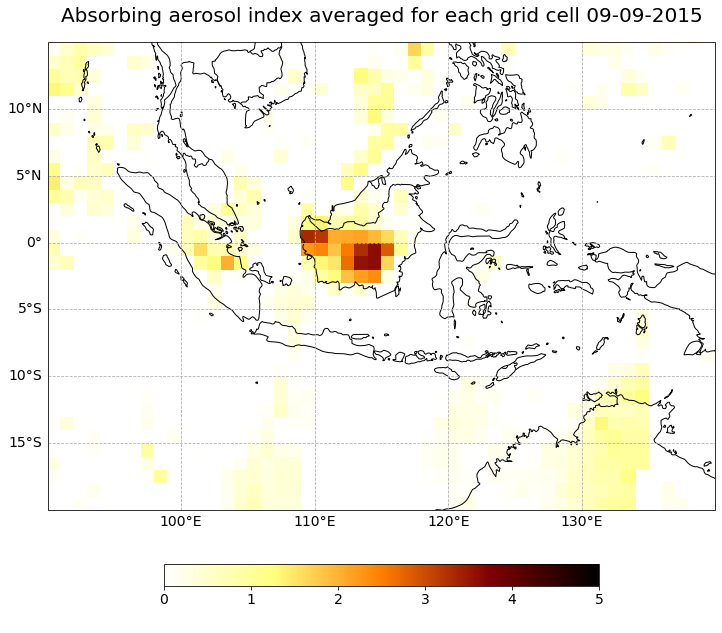

In [33]:
visualize_pcolormesh(data_array = aai_combined[:,:],
                     longitude = aai_combined.longitude, 
                     latitude = aai_combined.latitude,
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'afmhot_r', 
                     unit = ' ',
                     long_name = aai_a.long_name + ' ' + str(aai_gome2a.description.split()[4]), 
                     vmin = 0, 
                     vmax = 5,
                     latmin = latmin,
                     latmax = latmax,
                     lonmin = lonmin,
                     lonmax = lonmax,
                     set_global=False)


^ [Return to the top](#top)

## <a id='gome2_aah'></a> AC-SAF GOME-2 Level 2 Absorbing Aerosol Height data

The AC-SAF Metop-B GOME-2 Level 2 Absorbing Aerosol Height data is disseminated in the `HDF5` format. [xarray](http://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) are two Python libraries you can use to access and manipulate datasets in `HDF5` format.

### Load and browse AC-SAF Metop-B GOME-2 Level 2 product data

The AAH data is in the folder `/eodata/gome2/aah/`. The data in the `HDF5` file is organized in groups. AC-SAF Metop-B GOME-2 Level 2 data contain four groups:

* `DATA`
 * Absorbing Aerosol Height information
* `GEOLOCATION`
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* `METADATA`
 * General Metadata
* `PRODUCT_SPECIFIC_METADATA`
 * Product Metadata



You can load a `HDF5` file with the `Dataset` constructor of the [netCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library. Load the file in `diskless non-persistent` mode by setting the `diskless` argument to `True` and the `persist` argument to `False`.

The resulting object is a `netCDF4.Dataset` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

In [34]:
file_name = '../eodata/gome2/aah/2015/09/09/S-O3M_GOME_ARS_02_M01_20150909005657Z_20150909015657Z_R_O_20201120210202Z.hdf5'

file = Dataset(file_name, diskless=True, persist=False)

groups = file.groups.keys()
groups


dict_keys(['DATA', 'GEOLOCATION', 'METADATA', 'PRODUCT_SPECIFIC_METADATA'])

Each group contains multiple variables. You can print out the variables of each group nicely formatted. This gives you a helpful overview of available parameters. You will mostly be interested in parameters of the `GEOLOCATION` and `DATA` groups.

The overview shows you, that one Metop-B GOME-2 Level 2 data file contains information on `AAH_AbsorbingAerosolHeight`.

In [35]:
for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].variables.keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

DATA:
   - AAH_AbsorbingAerosolHeight    - AAH_AbsorbingAerosolHeightError- AAH_AbsorbingAerosolPressure
   - AAH_AbsorbingAerosolPressureError- AAH_ErrorFlag                 - AAH_NElements
   - AAH_QualityInput              - AAH_QualityProcessing         - AAH_RegimeFlag
   - AAI                           - DegradationCorrectedResidue   - NElements
   - PMD_CloudFraction             - PMD_SceneHomogeneity          - PMD_SnowIceFrac
   - QualityInput                  - QualityProcessing             - SunGlintFlag
   - UncorrectedResidue            

GEOLOCATION:
   - IndexInScan                   - LatitudeCenter                - LatitudeCorner
   - LineOfSightAzimuthAngle       - LineOfSightZenithAngle        - LongitudeCenter
   - LongitudeCorner               - NElements                     - NrOfPixelsInScan
   - RelAzimuthAngle               - ScanDirection                 - ScannerAngle
   - ScatteringAngle               - SolarAzimuthAngle             - SolarZenithAngle
   - S

### <a id='open_aah'></a>Open a `HDF5` group content as `xarray.Dataset` object

In a next step, you can make use of the `xarray.backends.NetCDF4DataStore` feature of the [xarray](http://xarray.pydata.org/en/stable/index.html) library to open the `HDF5` group you are interested in as a xarray `Dataset` object. It is important to know that you can only get hold of one `HDF5` group item at the time.

As an example, you can load the `DATA` group and open it as xarray `Dataset`. You see that the data has two dimensions: `phony_dim_0` and `phony_dim_1` and 19 data variables.

In [36]:
data = file['DATA']
xr_data = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
xr_data

<xarray.Dataset>
Dimensions:                            (phony_dim_0: 32, phony_dim_1: 588)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables:
    AAH_AbsorbingAerosolHeight         (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolHeightError    (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolPressure       (phony_dim_0, phony_dim_1) float32 ...
    AAH_AbsorbingAerosolPressureError  (phony_dim_0, phony_dim_1) float32 ...
    AAH_ErrorFlag                      (phony_dim_0, phony_dim_1) int32 ...
    AAH_NElements                      (phony_dim_1) int32 ...
    AAH_QualityInput                   (phony_dim_0, phony_dim_1) int32 ...
    AAH_QualityProcessing              (phony_dim_0, phony_dim_1) int32 ...
    AAH_RegimeFlag                     (phony_dim_0, phony_dim_1) int32 ...
    AAI                                (phony_dim_0, phony_dim_1) float32 ...
    DegradationCorrectedResidue        (phony_dim_0, phony_dim_1) float32 ...
    NElements                          (phony_dim_1) int32 ...
    PMD_CloudFraction                  (phony_dim_0, phony_dim_1) float32 ...
    PMD_SceneHomogeneity               (phony_dim_0, phony_dim_1) float32 ...
    PMD_SnowIceFrac                    (phony_dim_0, phony_dim_1) float32 ...
    QualityInput                       (phony_dim_0, phony_dim_1) int32 ...
    QualityProcessing                  (phony_dim_0, phony_dim_1) int32 ...
    SunGlintFlag                       (phony_dim_0, phony_dim_1) int32 ...
    UncorrectedResidue                 (phony_dim_0, phony_dim_1) float32 ...

### <a id='select_aah'></a>Select and retrieve one specific parameter from a `xarray.Dataset` object

Let's say, you are interested in the Absorbing Aerosol Height parameter. With `xarray`, you can retrieve the parameter using square brackets `[]` and the name of the parameter of interest. The resulting object is a `xarray.DataArray`, which has the shape of a one-dimensional vector.


In [37]:
aah = xr_data['AAH_AbsorbingAerosolHeight']
aah

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (phony_dim_0: 32, phony_dim_1: 588)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Dimensions without coordinates: phony_dim_0, phony_dim_1
Attributes:
    Title:          Absorbing Aerosol HeightQ
    Unit:           km8�0V
    FillValue:      -999.0
    ValidRangeMin:  -0.3
    ValidRangeMax:  200.0

### <a id='build_xr_aah'></a>Build a `xarray.DataArray` object for a Metop-A GOME-2 Level 2 parameter

For easier handling and plotting of the parameters, you can combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

You can make use of the function `generate_xr_from_1D_vec` which takes the following kwargs:
* `file` - the data file you want to load the data information from
* `lat_path` - internal paths to the latitude information of the HDF5 file
* `lon_path` - internal paths to the longitude information of the HDF5 file
* `variable` - xarray.DataArray with the variable information
* `parameter_name` - Name of the variable
* `longname` - Long name information of the variable
* `no_of_dims` - Number of dimensions of the data file
* `unit` - unit of the variable

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` object with latitude and longitude information and the AAH values as data values. The `DataArray` object contains 32 x 588 data pixels.

In [38]:
aah_xr = generate_xr_from_1D_vec(file = file, 
                                 lat_path = 'GEOLOCATION/LatitudeCenter', 
                                 lon_path = 'GEOLOCATION/LongitudeCenter', 
                                 variable = aah, 
                                 parameter_name = aah.name, 
                                 longname = aah.Title,
                                 no_of_dims = 2, 
                                 unit = aah.Unit)

aah_xr

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (x: 32, y: 588)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Coordinates:
    latitude   (x, y) float32 56.48 56.8 57.12 57.44 ... -999.0 -999.0 -999.0
    longitude  (x, y) float32 -75.82 -76.11 -76.41 ... -999.0 -999.0 -999.0
Dimensions without coordinates: x, y
Attributes:
    long_name:  Absorbing Aerosol HeightQ
    units:      km8�0V

### <a id='combine_aah'></a>Combine multiple HDF5 files in a `xarray.DataArray` object

AC-SAF Metop-B GOME-2 Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, you can apply the function `load_l2_data_xr`, which loads multiple `HDF5` files and returns a `xarray.DataArray` object with all ground pixels of all files. The function makes internally use of the function `generate_xr_from_1D_vec`.

Let us load all the AC-SAF Metop-B GOME-2 Level 2 data files for 9 September 2015. The function takes the following kwargs:
* `directory` - file directory containing the `HDF5` files
* `internal_filepath` - internal filepath containing the data information, e.g. `DATA`
* `parameter` - name of the parameter
* `lat_path` - path to the latitude information in the `HDF5` file
* `lon_path` - path to the longitude information in the `HDF5` file
* `no_of_dims` - Number of dimensions of the file
* `paramname` - Name of variable
* `unit` - Unit of the variable
* `longname` - Long name of the variable

In [39]:
directory='../eodata/gome2/aah/2015/09/09'
aah_da_mf = load_l2_data_xr(directory= directory,
                           internal_filepath='DATA',
                           parameter='AAH_AbsorbingAerosolHeight',
                           lat_path='GEOLOCATION/LatitudeCenter',
                           lon_path='GEOLOCATION/LongitudeCenter',
                           no_of_dims=2,
                           paramname=aah.name,
                           unit=aah.Unit,
                           longname=aah.Title)

aah_da_mf

<xarray.DataArray 'AAH_AbsorbingAerosolHeight' (ground_pixel: 507904)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 56.48 56.8 57.12 ... -999.0 -999.0
    longitude     (ground_pixel) float32 -75.82 -76.11 -76.41 ... -999.0 -999.0
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 560 561 562 563 564 565
Attributes:
    long_name:  Absorbing Aerosol HeightQ
    units:      km8�0V

<br>

### <a id='filter_aah'></a>Filter AAH values based on Absorbing Aerosol Index (AAI) information

Absorbing Aerosol Height information is strongly linked with Absorbing Aerosol Index values. AAI values below 2 index points correspond to scenes with too low amounts of aerosol to result in a reliable Absorbing Aerosol Height (AAH). These situations have already been flagged in the data file. However, even AAI values larger than 2 index points but smaller than 4 index points are often not thick enough for a reliable AAH retrieval. For this reason, we need to flag only the AAH values where the AAI values are larger than 4.

As a first step, you have to load the `AAI` values, which are part of the data files and can be found as well in the `DATA` group. You can use the function `load_l2_data_xr` to load the AAI values for all files for the same day.

In [40]:
aai = load_l2_data_xr(directory=directory,
                                    internal_filepath='DATA', 
                                    parameter='AAI', 
                                    lat_path='GEOLOCATION/LatitudeCenter', 
                                    lon_path='GEOLOCATION/LongitudeCenter', 
                                    no_of_dims=2, 
                                    paramname='AAI', 
                                    unit='-', 
                                    longname='Absorbing Aerosol Index')
aai

<xarray.DataArray 'AAI' (ground_pixel: 507904)>
array([-999., -999., -999., ..., -999., -999., -999.], dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 56.48 56.8 57.12 ... -999.0 -999.0
    longitude     (ground_pixel) float32 -75.82 -76.11 -76.41 ... -999.0 -999.0
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31
  - y             (ground_pixel) int64 0 1 2 3 4 5 6 ... 560 561 562 563 564 565
Attributes:
    long_name:  Absorbing Aerosol Index
    units:      -

In a next step, you can mask the AAH data array with the help of the previously loaded data array that contains the AAI values. You can use the function `generate_masked_array`. You want to filter out all AAH values, where AAI is less than 4 index points. As a result, only 592 AAH values remain valid.

In [41]:
aah_da_masked = generate_masked_array(aah_da_mf, aai, 4, '>', drop=True)
aah_da_masked

<xarray.DataArray (ground_pixel: 592)>
array([-9.99000000e+02, -9.99000000e+02,  1.75480068e+00,  2.77061939e+00,
        2.81509948e+00,  4.43458939e+00,  5.45265388e+00,  4.78292084e+00,
        5.38653374e+00,  6.61335611e+00,  6.91792393e+00,  3.92910576e+00,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,  6.95908356e+00,
        1.40496528e+00,  1.69520628e+00,  1.86400783e+00,  1.97569776e+00,
        1.92280185e+00,  1.73421562e+00,  1.50912261e+00,  1.46499979e+00,
        1.45935953e+00,  1.25700808e+00,  1.37371528e+00,  1.50049126e+00,
        8.23601544e-01,  1.19492269e+00,  1.45511472e+00,  1.41631353e+00,
        1.65150869e+00,  1.68193591e+00,  1.48872221e+00,  1.37278080e+00,
        1.63912427e+00,  4.90528286e-01,  4.49548095e-01,  1.68911731e+00,
        1.46100271e+00,  1.55173028e+00,  1.46848476e+00,  1.39284050e+00,
        1.14595807e+00,  9.67683196e-01,  9.24492061e-01,  7.92485893e-01,
        6.82738006e-01,  6.52655125e-01,  9.05216634e-01,  1.17096806e+00,
        1.31148887e+00,  1.44021773e+00,  1.70057797e+00,  1.43405688e+00,
        1.31719637e+00,  1.17506576e+00,  1.03409255e+00,  9.47328985e-01,
        8.13131869e-01,  6.83279097e-01,  8.74292731e-01,  1.16669703e+00,
        1.39783108e+00,  1.46706152e+00,  1.12488246e+00,  8.82599294e-01,
        8.85262311e-01,  8.97242665e-01,  7.76768208e-01,  6.66182816e-01,
        6.12116396e-01,  5.20099699e-01,  7.67301202e-01,  9.73506629e-01,
        1.23082244e+00,  1.43610454e+00,  1.33417273e+00,  1.32946467e+00,
...
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02, -9.99000000e+02, -9.99000000e+02,
       -9.99000000e+02, -9.99000000e+02,  7.07225657e+00,  7.10272932e+00],
      dtype=float32)
Coordinates:
    latitude      (ground_pixel) float32 16.26 15.02 -0.8558 ... 12.02 -7.408
    longitude     (ground_pixel) float32 128.7 127.6 115.1 ... 167.5 163.1
  * ground_pixel  (ground_pixel) MultiIndex
  - x             (ground_pixel) int64 5 6 18 18 25 25 25 ... 30 30 31 31 28 28
  - y             (ground_pixel) int64 287 291 341 342 339 ... 296 301 301 356
Attributes:
    long_name:  Absorbing Aerosol HeightQ
    units:      km8�0V

## <a id='visualize_aah'></a> Visualize filtered AAH values

In a last step, you can visualize again the data array with the filtered AAH information. You can use the function `visualize_scatter()` to do it. The function combines matplotlib's `scatter` functionality with Cartopy, a powerful library offering different projections for geographical data.

The `visualize_scatter` function takes the following kwargs:
* `xr_dataarray` - xarray.DataArray object
* `conversion_factor` - a number that can be used to convert data values
* `projection` - choose a cartopy projection
* `vmin` - Minimum value in the data range
* `vmax` - Maximum value in the data range
* `point_size` - size of the scatters
* `color_scale` - string of matplotlib's color ramp references
* `unit` - Unit of the data
* `title` - Title of the plot

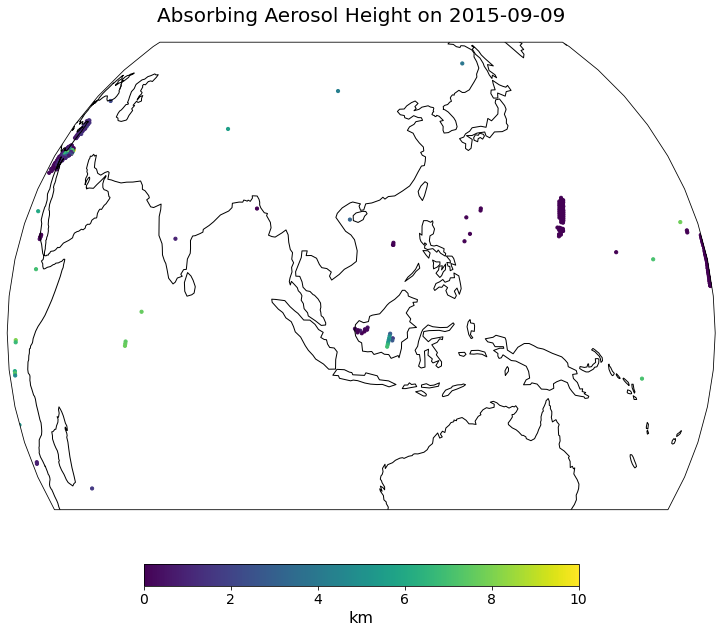

In [42]:
visualize_scatter(xr_dataarray=aah_da_masked, 
             conversion_factor=1,
             projection=ccrs.Orthographic(110), 
             vmin=0, 
             vmax=10, 
             point_size=10, 
             color_scale='viridis', 
             unit=aah_da_masked.units[0:2], 
             title=str(aah_da_masked.long_name)[0:24] + ' on 2015-09-09'
                 )

^ [Return to the top](#top)

<br>

<br>

## You have arrived at the end of this workflow highlighting the Indonesian fires of 2015.

<img src='../img/indonesia_fires_2015_2.jpg' alt='Indonesia Fires, source: https://www.theguardian.com/sustainable-business/2015/nov/11/indonesia-forest-fires-explained-haze-palm-oil-timber-burning' align='centre' width='60%'></img>

<i>Caption: Trees after a peatland fire on the outskirts of Palangkaraya city, Central Kalimantan. </i><br> Photograph: Bay Ismoyo/AFP/Getty Images, Images as featured in [The Guardian](https://www.theguardian.com/sustainable-business/2015/nov/11/indonesia-forest-fires-explained-haze-palm-oil-timber-burning).

^ [Return to the top](#top)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./316_fire_california_2020_Sentinel-3_SLSTR_NRT_AOD_L2.ipynb"><< 316 Californian Fires 2020 - Sentinel-3 SLSTR NRT AOD</a><span style="float:right;"><a href="./318_fire_indonesia_2020.ipynb">318 Indonesian Fires 2020 - Multi-data >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>

<br>